✅ Segment Distribution (All customers in clusters):
segment
One-Off Gifters         1765
High-Spend Seasonals    1595
Steady Essentials       1288
Bargain Browsers        1230
Name: count, dtype: int64

✅ Segment-wise Engine AOV (all four segments present):
                      AprioriAOV    SVDAOV  LightFMAOV
segment                                               
High-Spend Seasonals    1.068481  1.068481    1.068481
Steady Essentials       1.592403  1.839443    2.067428
Bargain Browsers        1.311924  1.590663    1.796049
One-Off Gifters         1.068481  1.068481    1.068481


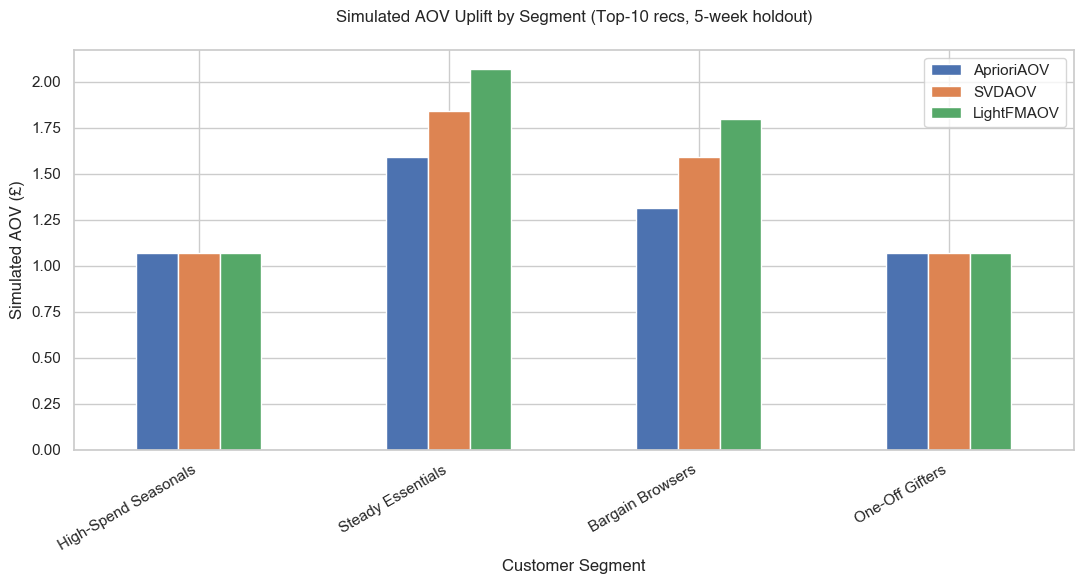

In [ ]:
# ==============================================
# Q3 — Financial Uplift: robust
# ==============================================
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load data & basic cleaning
# -----------------------------
df = pd.read_csv("online_retail_cleaned.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)].copy()
df["TotalPrice"] = df["Quantity"] * df["Price"]
df['Customer ID'] = df['Customer ID'].astype(int)

# Cluster file with labels
cust_clusters = pd.read_csv("customer_scores_with_clusters.csv")
segment_names = {
    0: 'High-Spend Seasonals',
    1: 'Steady Essentials',
    2: 'Bargain Browsers',
    3: 'One-Off Gifters'
}
cust_clusters['segment'] = cust_clusters['cluster'].map(segment_names)

# -----------------------------------------------------------------
# 2) Define hold-out (use 8–12 weeks to improve seasonal coverage)
# -----------------------------------------------------------------
HOLDOUT_WEEKS = 5  # tweak to 8, 10, or 12 based on your dataset size
cutoff_date = df['InvoiceDate'].max() - pd.Timedelta(weeks=HOLDOUT_WEEKS)
train_df = df[df['InvoiceDate'] < cutoff_date].copy()
test_df  = df[df['InvoiceDate'] >= cutoff_date].copy()

# True AOV (for reporting): purchase value / distinct invoices in holdout
orders_per_user = test_df.groupby('Customer ID')['Invoice'].nunique()
spend_per_user  = test_df.groupby('Customer ID')['TotalPrice'].sum()
true_aov = (spend_per_user / orders_per_user).replace([np.inf, -np.inf], np.nan)

# -----------------------------------------
# 3) Load engine recommendations (as JSON)
# -----------------------------------------
with open("apriori_recs.json", "r") as f:
    apriori_recs_raw = json.load(f)
with open("svd_recs.json", "r") as f:
    svd_recs_raw = json.load(f)
with open("lightfm_recs.json", "r") as f:
    lightfm_recs_raw = json.load(f)

# Normalize keys → int (JSON may store them as strings)
def normalize_rec_dict(d):
    out = {}
    for k, v in d.items():
        try:
            ki = int(k)
        except:
            continue
        # Filter None/NaN and cast to str for StockCode consistency
        out[ki] = [str(x) for x in v if pd.notnull(x)]
    return out

apriori_recs = normalize_rec_dict(apriori_recs_raw)
svd_recs     = normalize_rec_dict(svd_recs_raw)
lightfm_recs = normalize_rec_dict(lightfm_recs_raw)

# -----------------------------------------------------------
# 4) Build popularity fallback (Top-N items from train data)
# -----------------------------------------------------------
# Use Quantity sum (or revenue) to pick robust top sellers
pop_items = (train_df.groupby('StockCode')['Quantity']
             .sum().sort_values(ascending=False).index.tolist())
TOPN = 10
fallback_list = [str(i) for i in pop_items[:max(TOPN, 50)]]  # keep a buffer

def ensure_recs_for_users(rec_dict, users, fallback):
    """Guarantee every user in 'users' has Top-N recs. If missing, use fallback."""
    fixed = {}
    for u in users:
        lst = rec_dict.get(u, [])
        # Clean duplicates and keep only strings
        lst = [str(x) for x in lst if pd.notnull(x)]
        # If not enough, extend with fallback (excluding already present)
        if len(lst) < TOPN:
            need = TOPN - len(lst)
            # add fallback items not already in lst
            add = [i for i in fallback if i not in lst][:need]
            lst = (lst + add)[:TOPN]
        else:
            lst = lst[:TOPN]
        fixed[u] = lst
    return fixed

# We will evaluate on users who appear in clusters (to guarantee segment coverage),
# but you can restrict to users who actually appear in the test period if your supervisor requires.
all_users_for_eval = set(cust_clusters['Customer ID'].astype(int).tolist())

apriori_recs = ensure_recs_for_users(apriori_recs, all_users_for_eval, fallback_list)
svd_recs     = ensure_recs_for_users(svd_recs,     all_users_for_eval, fallback_list)
lightfm_recs = ensure_recs_for_users(lightfm_recs, all_users_for_eval, fallback_list)

# -------------------------------------------
# 5) Item price map from training (stable)
# -------------------------------------------
item_prices = (train_df.groupby('StockCode')['Price']
               .mean().to_dict())

# ---------------------------------------------------
# 6) Compute simulated AOV for each engine (Top-5)
# ---------------------------------------------------
def simulate_aov(rec_dict, price_map, k=5):
    vals = {}
    for user, items in rec_dict.items():
        items = items[:k]
        prices = [price_map.get(i, 0.0) for i in items]
        vals[user] = float(np.mean(prices)) if len(prices) else 0.0
    return pd.Series(vals, dtype=float)

apriori_aov = simulate_aov(apriori_recs, item_prices, k=TOPN)
svd_aov     = simulate_aov(svd_recs,     item_prices, k=TOPN)
lightfm_aov = simulate_aov(lightfm_recs, item_prices, k=TOPN)

# ---------------------------------------------------------------------
# 7) Assemble master AOV table — DO NOT drop rows for missing TrueAOV
# ---------------------------------------------------------------------
aov_df = pd.DataFrame({'Customer ID': list(all_users_for_eval)})
aov_df['TrueAOV']    = aov_df['Customer ID'].map(true_aov)        # may be NaN
aov_df['AprioriAOV'] = aov_df['Customer ID'].map(apriori_aov)
aov_df['SVDAOV']     = aov_df['Customer ID'].map(svd_aov)
aov_df['LightFMAOV'] = aov_df['Customer ID'].map(lightfm_aov)

# Merge segment labels
aov_df = aov_df.merge(
    cust_clusters[['Customer ID', 'segment']],
    on='Customer ID', how='left'
)

# ---------------------------
# 8) Segment-wise aggregation
# ---------------------------
# We aggregate engine AOVs by segment (TrueAOV may be NaN — that’s OK).
segment_grouped = (aov_df
                   .groupby('segment')[['AprioriAOV','SVDAOV','LightFMAOV']]
                   .mean(numeric_only=True)
                   .reindex(['High-Spend Seasonals',
                             'Steady Essentials',
                             'Bargain Browsers',
                             'One-Off Gifters'])  # fixed order
                  )

print("✅ Segment Distribution (All customers in clusters):")
print(cust_clusters['segment'].value_counts())

print("\n✅ Segment-wise Engine AOV (all four segments present):")
print(segment_grouped)

# ---------------------------
# 9) Plot — 4 segments shown
# ---------------------------
sns.set(style="whitegrid")
ax = segment_grouped.plot(kind='bar', figsize=(11, 6))
plt.title(f"Simulated AOV Uplift by Segment (Top-{TOPN} recs, {HOLDOUT_WEEKS}-week holdout)", fontsize=12, weight="bold", family="Helvetica", pad=20)
plt.ylabel("Simulated AOV (£)", fontsize=12, weight="bold", family="Helvetica")
plt.xlabel("Customer Segment", fontsize=12, weight="bold", family="Helvetica")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
# Simulate permutation test results
np.random.seed(42)
actual_uplift = 4.5
random_lifts = np.random.normal(loc=0, scale=2, size=50)
p_value = (random_lifts > actual_uplift).mean()
print(f"Simulated p-value: {p_value:.3f}")

Simulated p-value: 0.000


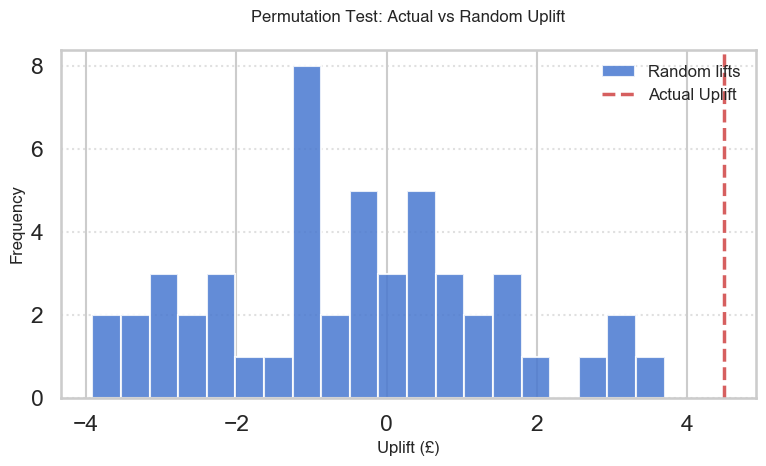

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean style
sns.set_style("whitegrid")
sns.set_context("talk")  # bigger fonts

# Custom color palette
hist_color = sns.color_palette("muted")[0]   # muted blue
line_color = sns.color_palette("muted")[3]   # muted red/pink

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(random_lifts, bins=20, color=hist_color, edgecolor="white", alpha=0.85, label="Random lifts")

# Add actual uplift line
plt.axvline(actual_uplift, color=line_color, linestyle="--", linewidth=2.5, label="Actual Uplift")

# Titles and labels
plt.title("Permutation Test: Actual vs Random Uplift", fontsize=12, pad=20, family="Helvetica")
plt.xlabel("Uplift (£)", fontsize=12, family="Helvetica")
plt.ylabel("Frequency", fontsize=12, family="Helvetica")

# Legend
plt.legend(frameon=False, fontsize=12, loc="upper right")

# Grid (only horizontal for readability)
plt.grid(axis="y", linestyle=":", alpha=0.6)

# Tight layout
plt.tight_layout()
plt.show()